<a href="https://colab.research.google.com/github/iraola/ML-anomaly-detection/blob/main/Tennessee_Eastman_process_AE_0731.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, n_neurons):
        super(Encoder, self).__init__()
        self.model = nn.Sequential()
        for i in range(len(n_neurons)):
            if i == 0:
                n_in = input_dim
            else:
                n_in = n_neurons[i - 1]
            n_out = n_neurons[i]
            self.model.add_module(f'enc{i + 1}', nn.Linear(n_in, n_out))
            self.model.add_module(f'enc{i + 1}_relu', nn.ReLU())

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, output_dim, n_neurons):
        super(Decoder, self).__init__()
        self.model = nn.Sequential()
        for i in range(len(n_neurons)-1, -1, -1):
            if i == len(n_neurons)-1:
                n_in = n_neurons[i]
            else:
                n_in = n_neurons[i+1]
            n_out = n_neurons[i]
            self.model.add_module(f'dec{i + 1}', nn.Linear(n_in, n_out))
            self.model.add_module(f'dec{i + 1}_relu', nn.ReLU())

        self.model.add_module('output', nn.Linear(n_neurons[0], output_dim))

    def forward(self, x):
        return self.model(x)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoder_neurons, decoder_neurons):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, encoder_neurons)
        self.decoder = Decoder(input_dim, decoder_neurons)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Example usage:
input_dim = 52  # Assuming each time point has 52 values
encoder_neurons = [32]  # Reduce dimension to 32
decoder_neurons = [32]  # Restore dimension to 52

autoencoder = Autoencoder(input_dim, encoder_neurons, decoder_neurons)

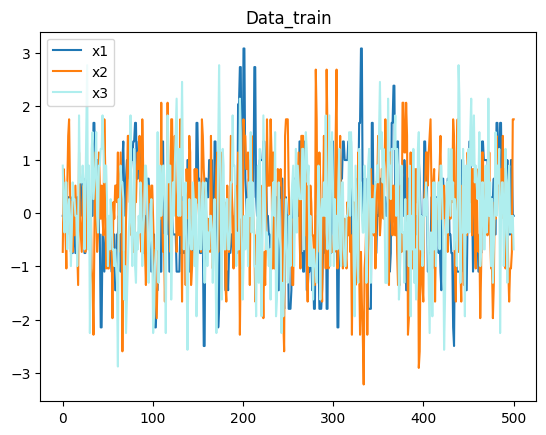

In [3]:
# Import the data set

# Read train data
filepath = 'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/train/d00.csv'
data_train = pd.read_csv(filepath)
data_train_np = data_train.values

# Normalize and plot train data
scaler = StandardScaler()

Data_train_nolabel = scaler.fit_transform(data_train_np[:,0:-1])
label_train = data_train_np[:,-1]
label_train = label_train.reshape((len(label_train), 1))
Data_train = np.concatenate((Data_train_nolabel, label_train), axis=1)
Data_train_df = pd.DataFrame(Data_train)
Data_train_df.columns = data_train.columns

x_axis_train = np.linspace(0, len(data_train), len(data_train))
plt.plot(x_axis_train, Data_train[:,0:2])
plt.plot(x_axis_train, Data_train[:,2], color='paleturquoise')
plt.title("Data_train")
plt.legend(labels=["x1","x2","x3"])
plt.show()

In [4]:
# Import data test1
filepath = 'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d01.csv'
data_test = pd.read_csv(filepath)
data_test_np = data_test.values

# Normalize and test data
Data_test_nolabel = scaler.transform(data_test_np[:,0:52])
label_test = data_test_np[:,52]
label_test = label_test.reshape((len(label_test), 1))
Data_test = np.concatenate((Data_test_nolabel, label_test), axis=1)
Data_test_df = pd.DataFrame(Data_test)
Data_test_df.columns = data_test.columns

Epoch 1/100, Loss: 0.842869758605957
Epoch 2/100, Loss: 0.8127167224884033
Epoch 3/100, Loss: 0.9478253126144409
Epoch 4/100, Loss: 0.8345441818237305
Epoch 5/100, Loss: 0.8581815361976624
Epoch 6/100, Loss: 1.0203206539154053
Epoch 7/100, Loss: 0.885604739189148
Epoch 8/100, Loss: 0.8869384527206421
Epoch 9/100, Loss: 0.8507051467895508
Epoch 10/100, Loss: 0.9752251505851746
Epoch 11/100, Loss: 0.9366371631622314
Epoch 12/100, Loss: 0.6930586099624634
Epoch 13/100, Loss: 1.10580313205719
Epoch 14/100, Loss: 0.6075394749641418
Epoch 15/100, Loss: 0.7763042449951172
Epoch 16/100, Loss: 0.956421971321106
Epoch 17/100, Loss: 0.9858007431030273
Epoch 18/100, Loss: 0.759732186794281
Epoch 19/100, Loss: 1.0096580982208252
Epoch 20/100, Loss: 0.8020874857902527
Epoch 21/100, Loss: 0.9521039128303528
Epoch 22/100, Loss: 0.8953037261962891
Epoch 23/100, Loss: 0.9815515279769897
Epoch 24/100, Loss: 0.9363206028938293
Epoch 25/100, Loss: 0.9850676655769348
Epoch 26/100, Loss: 0.9507781267166138
E

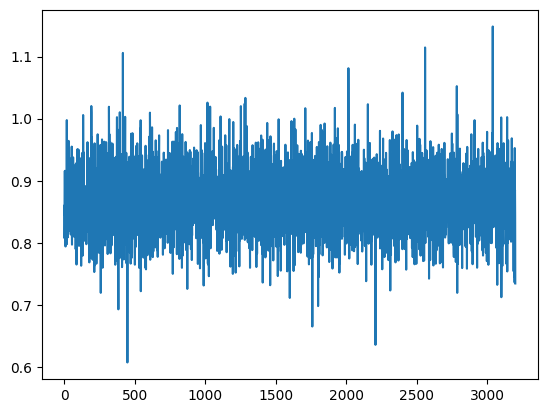

In [36]:
# Convert your data into PyTorch tensors before creating DataLoader
train_tensor = torch.tensor(Data_train_nolabel, dtype=torch.float32)
test_tensor = torch.tensor(Data_test_nolabel, dtype=torch.float32)

# Create DataLoader
batch_size = 16
train_dataset = TensorDataset(train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



test_dataset = TensorDataset(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Step 3: Train the autoencoder using the training data
criterion = nn.MSELoss()
optimizer = optim.SGD(autoencoder.parameters(), lr=0.00001)

model_loss = []

num_epochs = 100
for epoch in range(num_epochs):
    for data in train_loader:
        inputs = data[0] # Access the first element of the tuple, which contains the inputs
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        model_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

plt.plot(model_loss)

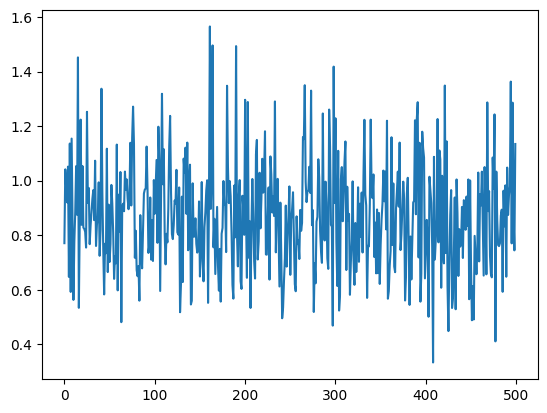

In [33]:
# Use train data again to tune the threshold
train_loader_tuning = DataLoader(train_dataset, batch_size=1, shuffle=True)

autoencoder.eval()  # Set the model to evaluation mode (no gradient computation)
train_losses_tuning = []
with torch.no_grad():
    for data in train_loader_tuning:
        inputs = data[0] # Access the first element of the tuple, which contains the inputs
        outputs = autoencoder(inputs)
        train_loss_tuning = criterion(outputs, inputs)
        train_losses_tuning.append(train_loss_tuning.item())

plt.plot(train_losses_tuning)

In [34]:
# Bisection method to tune the threshold
lower_bound = 0
upper_bound = max(train_losses_tuning)

tolerance = 0.001  # Tolerance level for accuracy
desired_accuracy = 0.99
while upper_bound - lower_bound > tolerance:
    # Calculate the current threshold
    current_threshold = (lower_bound + upper_bound) / 2

    # Find the indices of anomalies based on the current threshold
    anomalies_tuning = np.where(np.array(train_losses_tuning) > current_threshold)[0]

    # Create predicted labels based on anomalies
    y_pred_np_train = np.zeros(len(data_train), dtype=bool)
    y_pred_np_train[anomalies_tuning] = True
    y_pred_train = pd.DataFrame(y_pred_np_train)
    y_true_train = Data_train_df['label']

    # Calculate the accuracy based on the predicted and true labels
    accuracy_train = accuracy_score(y_true_train, y_pred_train)

    if accuracy_train == desired_accuracy:
        # The accuracy threshold is met
        threshold = current_threshold
        break
    elif accuracy_train > desired_accuracy:
        # Decrease the threshold
        upper_bound = current_threshold
    else:
        # Increase the threshold
        lower_bound = current_threshold

print("Tuned threshold:", threshold)
print("Achieved training accuracy:", accuracy_train)

Tuned threshold: 1.3696257025003433
Achieved training accuracy: 0.99


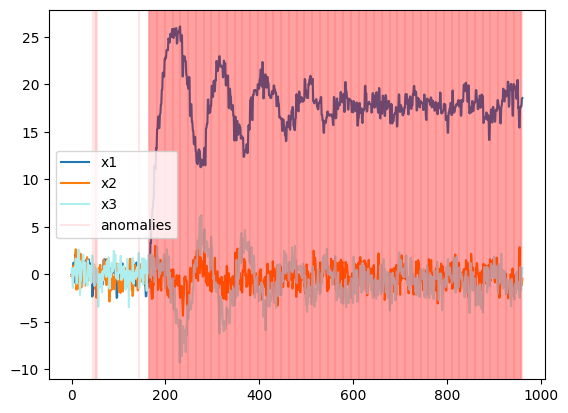

In [42]:
# Step 4: Evaluate the autoencoder using the test data
autoencoder.eval()  # Set the model to evaluation mode (no gradient computation)
test_losses = []
with torch.no_grad():
    for data in test_loader:
        inputs = data[0] # Access the first element of the tuple, which contains the inputs
        outputs = autoencoder(inputs)
        test_loss = criterion(outputs, inputs)
        test_losses.append(test_loss.item())

anomalies = np.where(np.array(test_losses) > threshold)[0]

 # visualize the result
x_axis_test = np.linspace(0, len(data_test), len(data_test))
plt.plot(x_axis_test, Data_test[:,0:2])
plt.plot(x_axis_test, Data_test[:,2], color='paleturquoise')
for line in anomalies:
  plt.axvline(x=line, color='r', alpha=0.1)
plt.legend(labels=['x1','x2','x3','anomalies'])
plt.show()

Test accuracy: 0.990625 Test precision: 0.9937578027465668 Test recall: 0.995 Test F1 score: 0.9943785134291068


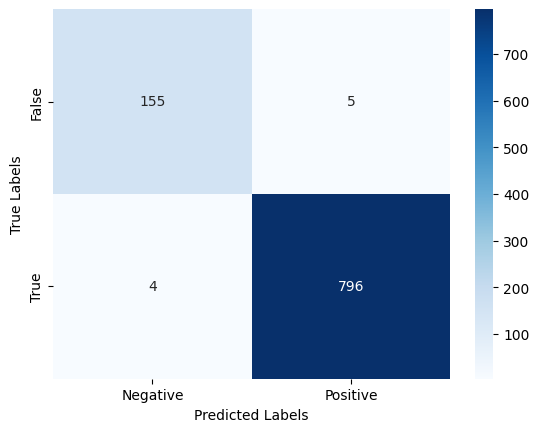

In [46]:
## Test the performance
y_pred_total = pd.DataFrame()
y_true_total = pd.DataFrame()
# Store predictions as '1' and '0'; or 'True' and 'False'
y_pred_np = np.zeros(len(data_test), dtype=bool)
y_pred_np[anomalies] = True
y_pred = pd.DataFrame(y_pred_np)
y_true = Data_test_df['label'].apply(lambda x: 1 if x != 0 else x)
y_pred_total = pd.concat([y_pred_total, y_pred], axis=0)
y_true_total = pd.concat([y_true_total, y_true], axis=0)


accuracy_test = accuracy_score(y_true, y_pred)
precision_test = precision_score(y_true, y_pred)
recall_test = recall_score(y_true, y_pred)
f1_test = f1_score(y_true, y_pred)

## Create a new row as a dictionary
print('Test accuracy:', accuracy_test, 'Test precision:', precision_test, 'Test recall:', recall_test, 'Test F1 score:', f1_test)

##Test_performance = Test_performance.append(new_row, ignore_index=True)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Define the labels for the matrix
x_labels = ['Negative','Positive']
y_labels = ['False','True']
# Create a heatmap visualization of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=x_labels, yticklabels=y_labels)
# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# Show the plot
plt.show()

In [32]:
# Assuming you already have the test_loader and test_losses as computed earlier

# Calculate the mean and standard deviation of the reconstruction errors in the test set
mean_test_loss = sum(test_losses) / len(test_losses)
std_test_loss = torch.tensor(test_losses).std()

# Set a threshold based on the mean and standard deviation
threshold = mean_test_loss + 2.0 * std_test_loss  # You can adjust the multiplier (2.0) as per your preference

# Perform anomaly detection
anomaly_indices = [i for i, loss in enumerate(test_losses) if loss > threshold]

# Print the anomaly indices and their corresponding reconstruction errors
print("Anomaly Indices and Reconstruction Errors:")
for i in anomaly_indices:
    print(f"Index {i}: Loss {test_losses[i]}")


Anomaly Indices and Reconstruction Errors:
Index 12: Loss 57.226097106933594
Index 13: Loss 52.350399017333984
Index 14: Loss 52.76063919067383
Index 15: Loss 46.078163146972656
Index 16: Loss 44.52898406982422
